In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import my_scripts.WiSe as WiSe
import matplotlib.pyplot as plt
import my_scripts.data_cleaning as dc
import my_scripts.TabNet_trainer as tn
import my_scripts.XGBoost_trainer as xg
import my_scripts.RidgeRegression_trainer as rr

# 2. Make Predictons
## A. Load the data

In [2]:
# load data and drop useless columns
df_train = pd.read_csv("hotel_bookings_train.csv")
df_test= pd.read_csv("hotel_bookings_test.csv")

def prepare_data(df):  
    unused_columns = ["agent", "company", "reservation_status", "reservation_status_date", "Unnamed: 0", "Set"] 
    df.drop(columns=unused_columns, inplace=True)

    # take care of non-value 
    df = df.dropna(how='any')
    df = df.reset_index(drop=True)
    
    # ordinal encoding 
    for non_numerical_feature_name in dc.non_numerical_features(df):
        dc.feature_ordinalEncoding(df, non_numerical_feature_name, inplace=True)
    return df

df_train = prepare_data(df_train)
df_test = prepare_data(df_test)

df = pd.concat([df_train, df_test]).reset_index(drop=True)

# define the target
target = "is_canceled"

## A. Pre-emptive Feature Selection

In [3]:
# apply univariate selection filters 
selected_pearson = WiSe.univariate_filter_spearman(df_train, target)
selected_spearman = WiSe.univariate_filter_spearman(df_train, target)
selected_univariate = list(set.union(set(selected_pearson), set(selected_spearman)))

In [4]:
# model selection based filtering 
selected_lasso = WiSe.model_selection_lasso(df_train, target, selected_univariate)
print("Remaining number of features: ", len(selected_lasso), "out of", df_train.shape[1] -1)

Remaining number of features:  22 out of 27


## C. Ridge Regression Predictions

Accuracy: 0.79
MCC Score: 0.55
F1 Score: 0.66


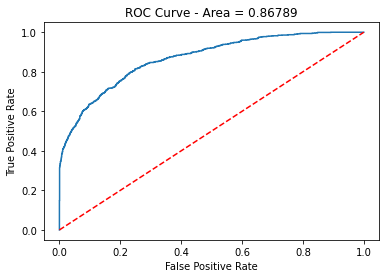

In [5]:
# ridge regression on the entire dataset 
rr_all = rr.RidgeRegression_classifer_trainer(df, target, std=True)
rr_all.train_model_on_best_params(learning_rates=[0.001, 0.01, 0.1], degrees=[1, 2, 3, 4], 
                                  n_components=[5, 10, 20, 25], end_evaluation=True)

Accuracy: 0.79
MCC Score: 0.54
F1 Score: 0.65


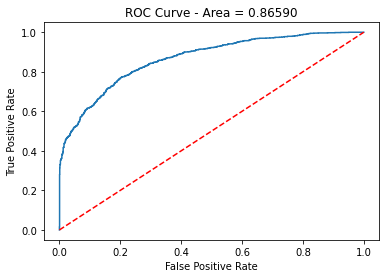

In [6]:
# ridge regression on selected features using WiSe
rr_WiSe = rr.RidgeRegression_classifer_trainer(df, target, std=True)
rr_WiSe.train_model_on_best_params(learning_rates=[0.001, 0.01, 0.1], degrees=[1, 2, 3, 4], 
                                  n_components=[5, 10, 20], end_evaluation=True, features=selected_lasso)

## D. XGBoost Predictions

C:\Users\pmansat\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\pmansat\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Accuracy: 0.76
MCC Score: 0.49
F1 Score: 0.52


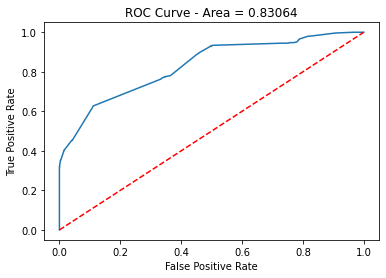

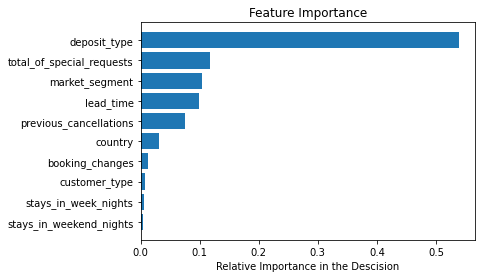

In [5]:
XGBoost_all = xg.XGBoost_classifier_trainer(df, target, split_test=True, learning_rate=0.01, max_depth=3, n_estimators=10)
XGBoost_all.train_model(end_evaluation=True)
XGBoost_all.print_feature_importance()

C:\Users\pmansat\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\pmansat\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Accuracy: 0.75
MCC Score: 0.50
F1 Score: 0.52


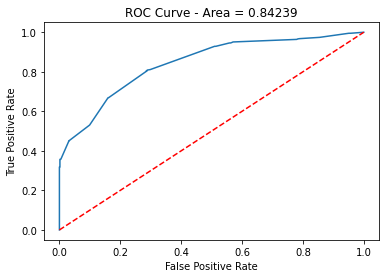

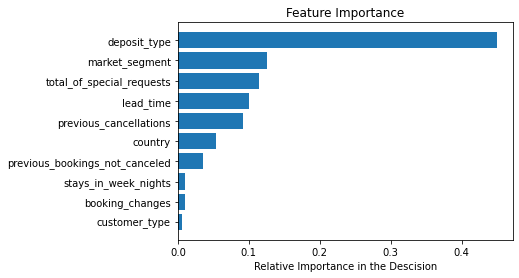

In [8]:
selected_xgboost = XGBoost_all.return_k_most_important_features(k=15)
XGBoost_selected = xg.XGBoost_classifier_trainer(df, target, split_test=True, learning_rate=0.01, max_depth=3, n_estimators=10)
XGBoost_selected.train_model(end_evaluation=True)
XGBoost_selected.print_feature_importance()

## E. TabNet Predictions

Stop training because you reached max_epochs = 100 with best_epoch = 98 and best_valid_auc = 0.84611
Best weights from best epoch are automatically used!
Accuracy: 0.72
MCC Score: 0.47
F1 Score: 0.69


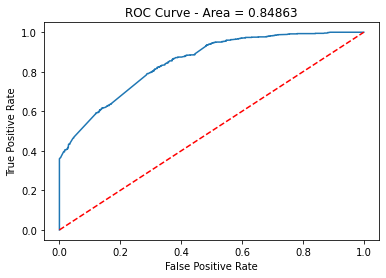

In [7]:
# predictions on full dataset
TabNet_full = tn.TabNet_binary_classifer_trainer(df, target, n_d=15, n_a=15, lr=0.1, lambda_sparse=1e-05, 
                                                 step_size=75, gamma=0.7)
TabNet_full.train_model(max_epochs=100, verbose=0, end_evaluation=True)

Stop training because you reached max_epochs = 100 with best_epoch = 97 and best_valid_auc = 0.84467
Best weights from best epoch are automatically used!
Accuracy: 0.77
MCC Score: 0.51
F1 Score: 0.62


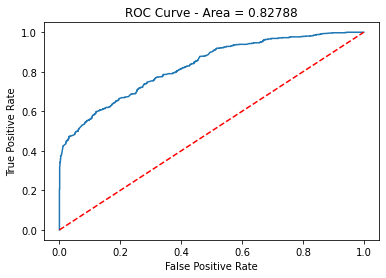

In [10]:
# predictions on features selected using WiSe methodology
TabNet_WiSe = tn.TabNet_binary_classifer_trainer(df, target, n_d=15, n_a=15, lr=0.1, lambda_sparse=1e-05, 
                                                 step_size=75, gamma=0.7)
TabNet_WiSe.train_model(max_epochs=100, verbose=0, end_evaluation=True, features=selected_lasso)

Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_valid_auc = 0.88532
Best weights from best epoch are automatically used!
Accuracy: 0.78
MCC Score: 0.56
F1 Score: 0.74


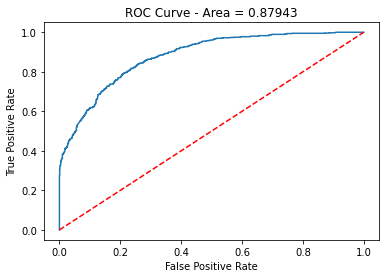

In [5]:
# predictions taking into account the class weight imbalance 
TabNet_WiSe_balance = tn.TabNet_binary_classifer_trainer(df, target, n_d=15, n_a=15, lr=0.1, lambda_sparse=1e-05, 
                                                 step_size=75, gamma=0.7)
TabNet_WiSe_balance.train_model(max_epochs=100, verbose=0, end_evaluation=True, weights=1, features=selected_lasso)